In [78]:
from clickhouse_driver import Client
from pandas.core.frame import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [79]:
client = Client(host='******',database="github_log")

In [80]:
# define weight function for evaluation algorithm
class Weight():
    def __init__(self):
        self.issueCommentWeight=1
        self.openIssueWeight=2
        self.openPullWeight=3
        self.pullReviewWeight=4
        self.mergePullWeight=5
    def culculate_weight():
        #culculate weights in different way
        pass
    
weight = Weight()
weight.issueCommentWeight

1

In [108]:
# evaluation function for 
db ='github_log'
table ='year2019'
topN = 1000000
repo_activity_sql = '''
SELECT contribute_list.repo_id AS repo_id,contribute_list.repo_name as repo_name, round(sum(sqrt(contribute_list.score)),2) AS repo_activity 
FROM
(SELECT
icc.repo_id AS repo_id, icc.repo_name as repo_name, icc.actor_id AS actor_id, {issueCommentWeight}*icc.count+{openIssueWeight}*oic.count+{openPullWeight}*opc.count+{pullReviewWeight}*rcc.count+{mergePullWeight}*mpc.count AS score
FROM
(SELECT repo_id, repo_name, actor_id, COUNT(*) count FROM {db}.{table} WHERE type='IssueCommentEvent' AND action='created' GROUP BY repo_id,repo_name, actor_id) AS icc
LEFT JOIN
(SELECT repo_id,repo_name, actor_id, COUNT(*) count FROM {db}.{table} WHERE type='IssuesEvent' AND action='opened' GROUP BY repo_id,repo_name, actor_id) AS oic
ON icc.repo_id=oic.repo_id AND icc.actor_id=oic.actor_id 
LEFT JOIN
(SELECT repo_id,repo_name, actor_id, COUNT(*) count FROM {db}.{table} WHERE type='PullRequestEvent' AND action='opened' GROUP BY repo_id,repo_name, actor_id) AS opc
ON icc.repo_id=opc.repo_id AND icc.actor_id=opc.actor_id 
LEFT JOIN
(SELECT repo_id,repo_name, actor_id, COUNT(*) count FROM {db}.{table} WHERE type='PullRequestReviewCommentEvent' AND action='created' GROUP BY repo_id,repo_name, actor_id) AS rcc
ON icc.repo_id=rcc.repo_id AND icc.actor_id=rcc.actor_id
LEFT JOIN
(SELECT repo_id,repo_name, issue_author_id AS actor_id, COUNT(*) as count FROM {db}.{table} WHERE type='PullRequestEvent' AND action='closed' AND pull_merged=1 GROUP BY repo_id,repo_name, actor_id) AS mpc
ON icc.repo_id=mpc.repo_id AND icc.actor_id=mpc.actor_id) AS contribute_list
GROUP BY repo_id,repo_name
ORDER BY repo_activity DESC
LIMIT {topN}
'''.format(issueCommentWeight=weight.issueCommentWeight,openIssueWeight=weight.openIssueWeight,openPullWeight=weight.openPullWeight,pullReviewWeight=weight.pullReviewWeight,mergePullWeight=weight.mergePullWeight,db=db,table=table,topN=topN)
#print (repo_activity_sql)


In [109]:
%%time
result = client.execute(repo_activity_sql)

CPU times: user 2.46 s, sys: 540 ms, total: 3 s
Wall time: 31.9 s


In [60]:
result

[(41881900, 'microsoft/vscode', 32218.32),
 (31792824, 'flutter/flutter', 27281.91),
 (72685026, 'MicrosoftDocs/azure-docs', 24634.82),
 (101804230, 'Microsoft/openenclave', 23713.73),
 (101804230, 'openenclave/openenclave', 22296.79),
 (101804230, 'microsoft/openenclave', 22199.29),
 (41881900, 'Microsoft/vscode', 21649.35),
 (20580498, 'kubernetes/kubernetes', 21485.27),
 (45717250, 'tensorflow/tensorflow', 19645.75),
 (84835535, 'carbon-design-system/carbon', 19203.62),
 (177736533, '996icu/996.ICU', 18794.18),
 (12888993, 'home-assistant/home-assistant', 16381.35),
 (3638964, 'ansible/ansible', 15423.78),
 (84835535, 'IBM/carbon-components', 15392.22),
 (100060912, 'microsoft/terminal', 14941.68),
 (20929025, 'microsoft/TypeScript', 14518.31),
 (4542716, 'NixOS/nixpkgs', 13974.94),
 (46806184, 'helm/charts', 13879.87),
 (84835535, 'carbon-design-system/carbon-components', 13483.96),
 (36040894, 'gatsbyjs/gatsby', 13256.81),
 (2698821, 'medic/medic', 12804.05),
 (29028775, 'facebook

In [110]:
top100w_repo= DataFrame(result)
top100w_repo.rename(columns={0:'repo_id',1:'repo_name',2:"score"},inplace=True)
top100w_repo

,repo_id,repo_name,score
0,41881900,microsoft/vscode,32218.32
1,31792824,flutter/flutter,27281.91
2,72685026,MicrosoftDocs/azure-docs,24634.82
3,101804230,Microsoft/openenclave,23713.73
4,101804230,openenclave/openenclave,22296.79
...,...,...,...
999995,152712536,tfciw/tfciw.github.io,2.45
999996,180343871,TomasTomecek/release-bot-test-leNb6whHyl9JOjvA,2.45
999997,110060032,clippedjs/clipped,2.45
999998,187361935,jrmay/flask-boilerplate,2.45


In [111]:
top100w_repo.to_csv('csv/top10w_repo.csv',index=None)

In [315]:
top100w_repo.head(1000)

,repo_id,repo_name,score
0,41881900,microsoft/vscode,32218.32
1,31792824,flutter/flutter,27281.91
2,72685026,MicrosoftDocs/azure-docs,24634.82
3,101804230,Microsoft/openenclave,23713.73
4,101804230,openenclave/openenclave,22296.79
...,...,...,...
995,118654121,GoogleContainerTools/skaffold,1665.26
996,210716005,dotnet/runtime,1664.20
997,81963350,neurodata/SPORF,1661.85
998,3199002,raspberrypi/linux,1659.62


In [88]:
df = top100w_repo
# df['repo_split'] = df['repo_name'].str.split('/')
# df

In [75]:
df['org'], df['repo'] = df['repo_name'].str.split('/', 1).str
df

KeyError: 'repo_name'

In [325]:
grouped= df.groupby('org')
grouped_count= df.groupby('org').count()
sum_score = DataFrame(grouped['score'].agg(np.sum))
sum_score['count'] = grouped_count['repo']
ordered_org = sum_score.sort_values(by='score',ascending=False)
ordered_org=ordered_org.reset_index()
ordered_org.head(20)

,org,score,count
0,microsoft,461722.51,1173
1,Microsoft,362664.34,856
2,apache,156363.69,810
3,Azure,85448.80,563
4,MicrosoftDocs,78392.40,475
5,dotnet,71951.66,138
6,kubernetes,62801.10,72
7,google,55024.77,703
8,openshift,53011.81,278
9,mozilla,49697.35,484


In [301]:
## search for the specific rank of a organization
ordered_org.loc[ordered_org.org=='996icu']

,org,score,count
50,996icu,18869.03,2


In [324]:
#get repos from orgs
org = 'odoo'
sql_distinct_repo_fuzzy ="""select distinct repo_id, repo_name from github_log.year2019 where repo_name LIKE '{org}/%' """.format(org=org)
result_org_repos = client.execute(sql_distinct_repo_fuzzy)
data_org_repos = DataFrame(result_org_repos)
data_org_repos.rename(columns={0:'repo_id',1:'repo_name'},inplace=True)
print ("***********All repositores of this organization***********:\n",data_org_repos,'\n')

print ("***********org rank in evaluation result***********:\n",ordered_org.loc[ordered_org.org==org],"\n")

print ("***********repos of this org in Top 1,000,000 repo list:***********")
for i in list(grouped.groups[org]):
    print (df.repo_name[i])

***********All repositores of this organization***********:
       repo_id                          repo_name
0    19745004                          odoo/odoo
1    38825372            odoo/documentation-user
2   178364606                           odoo/owl
3    27810657                        odoo/docker
4   124407257                        odoo/runbot
5    25257141                  odoo/ngx_postgres
6   148126071  odoo/technical-training-solutions
7   114105191                    odoo/OdooLocust
8   124551505             odoo/ps-runbot-testing
9    62393953            odoo/technical-training
10   27810472        odoo/docker-official-images
11  122975814               odoo/odoo-client-lib
12   20168931                    odoo/odoo-extra
13   27810630                   odoo/docker-docs
14  228355690                 odoo/x-spreadsheet
15   24884386                      odoo/petstore
16   20027630                 odoo/odoodays-2014
17   31259962          odoo/functional-mementoes
18  1017

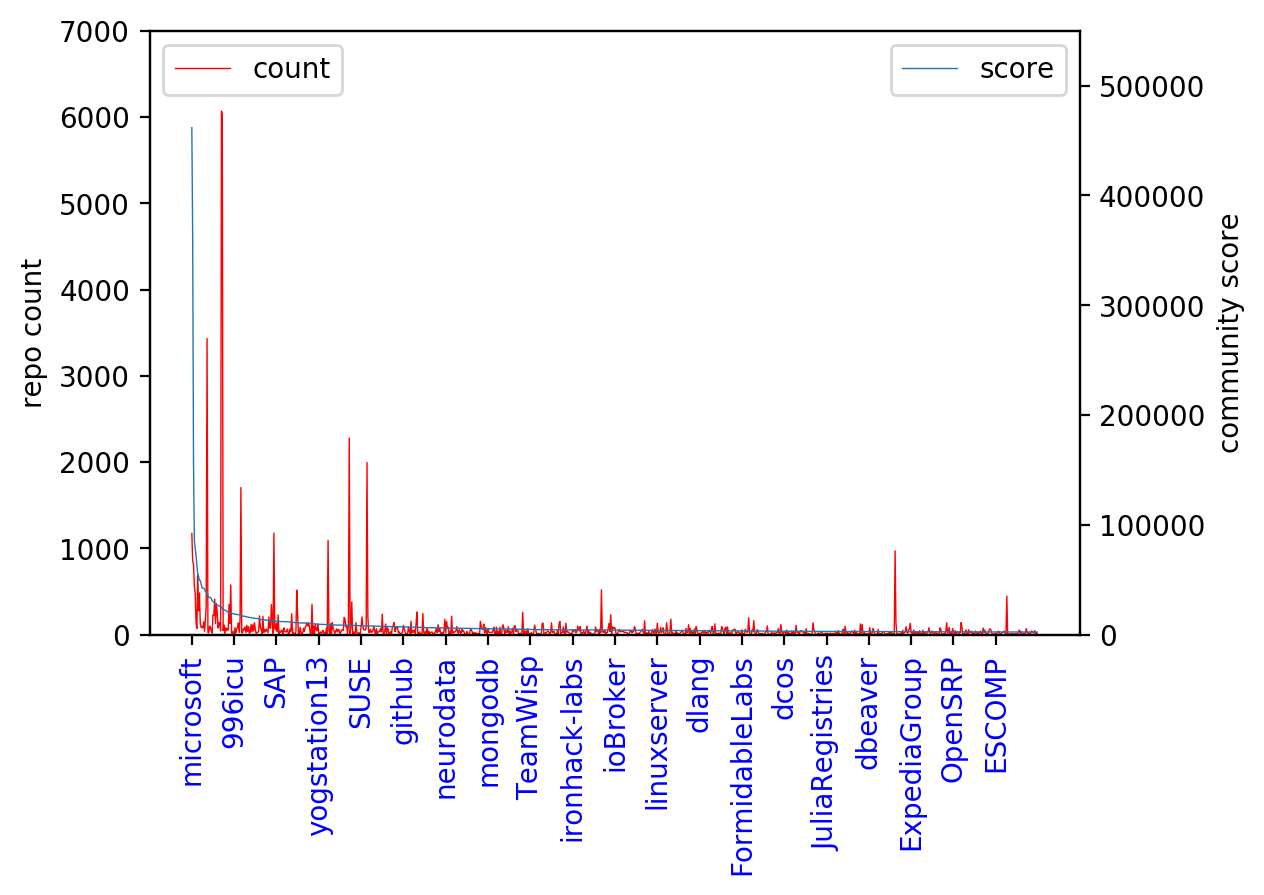

In [317]:
top_k=1000
stride = 50
df_head=ordered_org.head(top_k).reset_index()

fig,ax = plt.subplots(1,1)
x_label= tuple(df_head['org'])[:top_k:stride]
plt.xticks(range(0,top_k,stride),x_label,color='blue', rotation=90)

ax.plot(df_head['count'],'r',label='count',linewidth=0.5)
plt.ylabel('repo count')
ax.set_ylim(0,7000)
ax.legend(loc=2)
ax1=ax.twinx()
plt.ylabel("community score")
ax1.plot(df_head['score'],label='score',linewidth=0.5)
ax1.set_ylim(0,550000)
ax1.legend(loc=0)
plt.show()


In [332]:
df_head.head(50)

,index,org,score,count
0,0,microsoft,461722.51,1173
1,1,Microsoft,362664.34,856
2,2,apache,156363.69,810
3,3,Azure,85448.80,563
4,4,MicrosoftDocs,78392.40,475
5,5,dotnet,71951.66,138
6,6,kubernetes,62801.10,72
7,7,google,55024.77,703
8,8,openshift,53011.81,278
9,9,mozilla,49697.35,484


In [96]:
%%time
sql_distinct_repo="""
    select repo_id, sum(repo_size) as sum_repo_size, COUNT(*) as  count from github_log.year2019 where type = 'PullRequestEvent' or type='PullRequestReviewCommentEvent' group by repo_id
"""
columns =['repo_id','sum_repo_size','count']
result_distinct_repo =  client.execute(sql_distinct_repo)
data= DataFrame(result_distinct_repo,columns=columns)
#data.rename(columns={0:'repo_id',1:'repo_name'},inplace=True)
data

CPU times: user 8.86 s, sys: 2.15 s, total: 11 s
Wall time: 17.7 s


,repo_id,sum_repo_size,count
0,182442095,2,1
1,102489878,314,3
2,57603241,263770,2
3,189985412,31720,16
4,138532144,2240,1
...,...,...,...
4535124,179541372,508,4
4535125,226898780,24702,2
4535126,189188336,49044,1
4535127,208422584,25,8


In [97]:
data.eval("avg_repo_size = sum_repo_size / count",inplace =True)

In [98]:
data.loc[data.repo_id==41881900]

,repo_id,sum_repo_size,count,avg_repo_size
925440,41881900,1179645770,5681,207647.556768


In [112]:
df_top10w = pd.read_csv('csv/top10w_repo.csv')
df_top10w

,repo_id,repo_name,score
0,41881900,microsoft/vscode,32218.32
1,31792824,flutter/flutter,27281.91
2,72685026,MicrosoftDocs/azure-docs,24634.82
3,101804230,Microsoft/openenclave,23713.73
4,101804230,openenclave/openenclave,22296.79
...,...,...,...
999995,152712536,tfciw/tfciw.github.io,2.45
999996,180343871,TomasTomecek/release-bot-test-leNb6whHyl9JOjvA,2.45
999997,110060032,clippedjs/clipped,2.45
999998,187361935,jrmay/flask-boilerplate,2.45


In [113]:
df_new = pd.merge(df_top10w,data,how='inner',on='repo_id')

In [114]:
df_new

,repo_id,repo_name,score,sum_repo_size,count,avg_repo_size
0,41881900,microsoft/vscode,32218.32,1179645770,5681,2.076476e+05
1,41881900,Microsoft/vscode,21649.35,1179645770,5681,2.076476e+05
2,31792824,flutter/flutter,27281.91,2130359081,31723,6.715503e+04
3,72685026,MicrosoftDocs/azure-docs,24634.82,104239222048,13733,7.590419e+06
4,101804230,Microsoft/openenclave,23713.73,1285528786,5787,2.221408e+05
...,...,...,...,...,...,...
814778,184644557,Artyom-Ganev/getting-started-github-apps,2.45,0,1,0.000000e+00
814779,144649680,brightcove/typed-immutable-extensions,2.45,11393,13,8.763846e+02
814780,152712536,tfciw/tfciw.github.io,2.45,207,1,2.070000e+02
814781,180343871,TomasTomecek/release-bot-test-leNb6whHyl9JOjvA,2.45,0,1,0.000000e+00


In [115]:
size = sum(df_new.avg_repo_size)

In [116]:
size_m=(size/1024)
size_g=size_m/1024
size_t=size_g/1024
size_t

15.263590451940523

In [ ]:
full_size = sum(data.repo_size)

In [35]:
%%time
sql_distinct_repo="""
    select distinct actor_id, actor_login from github_log.year2019 where type='IssueCommentEvent' or type='IssuesEvent' 
"""
columns =['actor_id','actor_login']
result_distinct_repo =  client.execute(sql_distinct_repo)
data= DataFrame(result_distinct_repo,columns=columns)
data.head()

CPU times: user 4.66 s, sys: 453 ms, total: 5.11 s
Wall time: 6.78 s


,actor_id,actor_login
0,4,wycats
1,7,evanphx
2,17,vanpelt
3,21,technoweenie
4,26,topfunky


In [36]:
data

,actor_id,actor_login
0,4,wycats
1,7,evanphx
2,17,vanpelt
3,21,technoweenie
4,26,topfunky
...,...,...
2762366,48075121,Otisdahousekats
2762367,48075141,Eshesheshesh
2762368,48075219,Tonights
2762369,48075225,remolin


In [9]:
data.to_csv("csv/actor_list_2019.csv",index=None)

In [11]:
df = pd.read_csv("csv/2019_high_degree_nodes_with_genders_list.csv")

In [12]:
df

,actor_id,actor_login,degree,gender
0,6697940,houndci-bot,1127,NaN
1,42910462,golangcibot,794,NaN
2,19940114,codacy-bot,625,NaN
3,30008653,hound[bot],520,NaN
4,36754821,codeclimate[bot],447,NaN
...,...,...,...,...
26301,2619836,davidfurey,10,NaN
26302,18348847,brechmos-stsci,10,NaN
26303,1047914,dadgar,10,NaN
26304,1572228,tomplus,10,NaN


In [15]:
group = df.groupby('gender')

result = [x for x in group]

In [17]:
result[0]

('female',
        actor_id         actor_login  degree  gender
 18      2584963             drashna     292  female
 33      1404810              SimenB     216  female
 62       216080               nikic     188  female
 65     12971179              mairaw     186  female
 78      1804568           thaJeztah     178  female
 ...         ...                 ...     ...     ...
 26210  38249778  MariaShaposhnikova      10  female
 26214  56076012        HalynaDumych      10  female
 26259  30920819    GenevieveBuckley      10  female
 26277  22536765              filizt      10  female
 26278  37741324     RituRajSingh878      10  female
 
 [965 rows x 4 columns])

In [25]:
for i in result[1]:
    print (i)

male
       actor_id     actor_login  degree gender
7       3181692  MartinHjelmare     404   male
24       609873         WillAyd     238   male
27      1312546   TomAugspurger     235   male
28       995707      OskarStark     235   male
32       235188           tedyu     216   male
...         ...             ...     ...    ...
26286   1043168         yash620      10   male
26288   5237744          lbenet      10   male
26292   1044345           smite      10   male
26295   9958300       IceMimosa      10   male
26300  14154141  michaelDCurran      10   male

[3136 rows x 4 columns]
